# Hyperflow 2023: *Python for FCM (forget R 😉)*

This notebook gives a brief introduction of processing Flow Cytometry (FCM) data with python. Most of the featured examples are based on the open-source Python framework [Cytoflow](https://cytoflow.readthedocs.io/en/stable/). Please check it out for further information.

First we import matplotlib (a plotting framework for python) and cytoflow. We configure some default settings to enable larger plots in this notebook.

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

import cytoflow as flow
flow.DefaultKWArgs["height"] = 5

#### Reading FCS files

Next we read in FCM measurements. We can either read  data from a FCS-file or from a CSV-file.

In [52]:
basepath = "./cytoflow/tests/data/vie14/"
tube1 = flow.Tube(file = basepath + '494.csv')
ex = flow.ImportOp(tubes = [tube1]).apply()

Everything in Cytoflow is build around experiments. An experiment is the primary object that holds FCM measurements and metadata of several tubes. Core structure within the experiment is a Pandas Dataframe:

In [53]:
ex.data

,TIME,FSC-A,FSC-W,SSC-A,CD20,CD10,CD45,CD34,SY41,CD19,CD38,APC-CY7-A
0,0.256109,0.724819,0.000000,0.993575,0.511647,0.737258,3.116999,0.610369,2.394137,2.838983,1.824015,1.053927
1,0.256109,2.111998,1.095594,0.789835,2.883300,4.009430,3.395909,2.123596,3.296094,2.423301,1.525653,1.349321
2,0.256109,2.071740,1.094057,4.499983,1.406279,1.910993,2.866903,0.984716,3.535055,1.830034,2.072034,0.882448
3,0.256150,1.923883,1.095217,0.648713,1.031393,4.020207,2.840137,0.942146,3.296256,2.922170,1.724284,0.740326
4,0.256190,1.580198,1.005982,0.781159,1.264268,1.307244,3.775684,0.514218,2.890679,1.018567,1.652686,0.857172
...,...,...,...,...,...,...,...,...,...,...,...,...
83406,4.499838,4.229612,1.110860,4.499983,1.581865,1.840961,2.920752,1.529190,3.640661,1.976877,2.090316,0.663859
83407,4.499919,1.721509,1.086372,0.589498,2.136454,3.867376,3.045547,2.038175,2.996041,1.974872,2.348283,0.862303
83408,4.499959,1.888425,1.035353,1.412427,3.039960,4.131422,3.501659,2.281008,3.293125,3.573528,3.040444,1.108402
83409,4.500000,1.479483,1.069826,0.567807,1.333666,4.141739,3.046796,1.852519,3.120067,2.561236,1.447637,0.767203


Pandas Dataframes are one of the most commonly used structures when manipulating tabular data in Python. We can do all sort of things with it like selecting, transforming and cleaning data instances.

## Views in Cytoflow
Let's plot our experiment with Cytoflow. We first define a View where we specify which channels we want to visualize. And then we use this view to plot our previously created experiment. Cytoflow always follows this pattern: First we define the parameters of our view and then we plot it with a particular experiment.

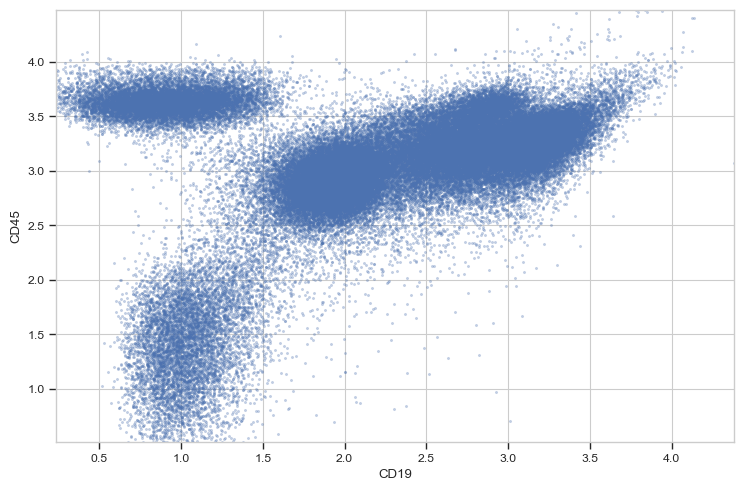

In [81]:
scatter_cd19cd45 = flow.ScatterplotView(xchannel = 'CD19', ychannel = 'CD45')
scatter_cd19cd45.plot(ex)

There are many different views in Cytoflow such as Histograms, Bar Charts, Violin Plots or Kernel Density Estimates.

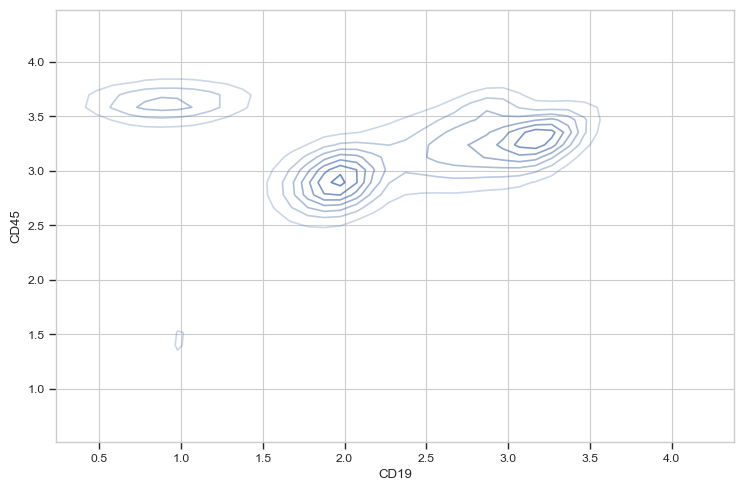

In [82]:
kde_cd19cd45 = flow.Kde2DView(xchannel = 'CD19', ychannel = 'CD45') 
kde_cd19cd45.plot(ex)

Besides *Views* there are exists *Operations* that allows us to manipulate experiments in Cytoflow. Consider the ThresholdOperation:

In [83]:
cd19_thresh = flow.ThresholdOp(name = "CD19pos",channel = 'CD19', threshold = 1.5)

ex2 = cd19_thresh.apply(ex)



We first defined the Operation and then applied to our experiment. This results in a new experiments, which now contains a condition that indicates which events are above the threshold which are below.

In [56]:
ex2.conditions

{'CD45pos': 0    False
 dtype: bool}

## Operations in Cytoflow
Operations in Cytoflow also often have a default view that visualizes the Operation applied to an experiment.

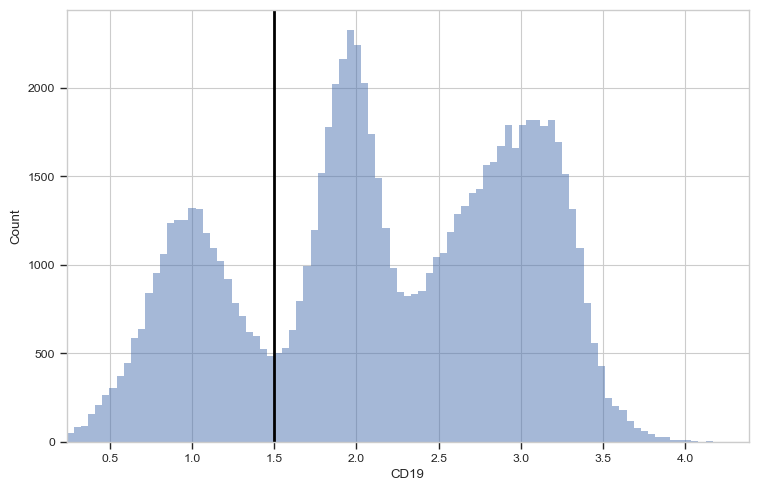

In [84]:
cd19_thresh.default_view().plot(ex2)

We can now also use the CD19pos condition to add color to our scatter plot:

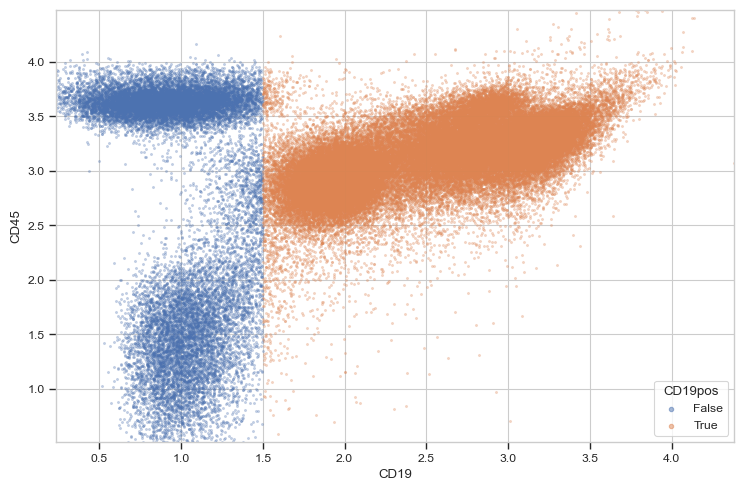

In [85]:
scatter_cd19cd45.huefacet = 'CD19pos'
scatter_cd19cd45.plot(ex2)

We can do the same with our KDE plot.

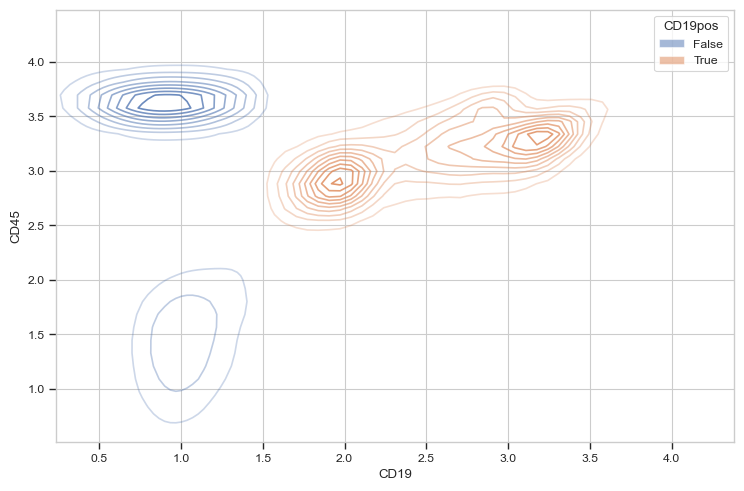

In [98]:
kde_cd19cd45.huefacet = 'CD19pos'
kde_cd19cd45.plot(ex2)

We can also load predefined conditions from a file. Like here we load conditions from a csv files that present that result of manuell gating applied to our sample.

In [59]:
human_conditions = flow.BulkConditionOp(conditions_csv_path =  basepath + '494_labels.csv',
                                      combine_order = ["syto", "singlets", "intact","cd19", "blast"],
                                      combined_conditions_name="human_gt",
                                      combined_condition_default ="other")

ex3 = human_conditions.apply(ex2)

Each column in this CSV-File specifies if a particular event is inside the given gate. We define a combine order which essientially defines the gating hierachy. With this we end up with a column that shows the name of the last gate a event is into.
We can see the difference when we now observe our dataframe. We have a new column foreach gate as we as a combined column showing the "cell type".

In [86]:
ex3.data

,TIME,FSC-A,FSC-W,SSC-A,CD20,CD10,CD45,CD34,SY41,CD19,...,index,allevents,syto,singlets,intact,erythropoiesis,cd19,cd20,blast,human_gt
0,0.256109,0.724819,0.000000,0.993575,0.511647,0.737258,3.116999,0.610369,2.394137,2.838983,...,False,True,False,False,False,False,False,False,False,other
1,0.256109,2.111998,1.095594,0.789835,2.883300,4.009430,3.395909,2.123596,3.296094,2.423301,...,True,True,True,True,True,False,True,False,True,blast
2,0.256109,2.071740,1.094057,4.499983,1.406279,1.910993,2.866903,0.984716,3.535055,1.830034,...,True,True,True,True,True,False,False,False,False,intact
3,0.256150,1.923883,1.095217,0.648713,1.031393,4.020207,2.840137,0.942146,3.296256,2.922170,...,True,True,True,True,True,False,True,False,True,blast
4,0.256190,1.580198,1.005982,0.781159,1.264268,1.307244,3.775684,0.514218,2.890679,1.018567,...,True,True,True,True,True,False,False,False,False,intact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83406,4.499838,4.229612,1.110860,4.499983,1.581865,1.840961,2.920752,1.529190,3.640661,1.976877,...,True,True,True,True,True,False,False,False,False,intact
83407,4.499919,1.721509,1.086372,0.589498,2.136454,3.867376,3.045547,2.038175,2.996041,1.974872,...,True,True,True,True,True,False,True,False,True,blast
83408,4.499959,1.888425,1.035353,1.412427,3.039960,4.131422,3.501659,2.281008,3.293125,3.573528,...,True,True,True,True,True,False,True,False,True,blast
83409,4.500000,1.479483,1.069826,0.567807,1.333666,4.141739,3.046796,1.852519,3.120067,2.561236,...,True,True,True,True,True,False,True,False,True,blast


We now can use this human generated ground truth to subsample our FCM data in a useful way. We specify with the SubsampleOp that we want 10% of each label that is present in human_gt.

In [87]:
subsample_op = flow.SubsampleOp(sampling_type = "relative", sampling_def = {"human_gt":"0.1:FromEach"})

ex4 = subsample_op.apply(ex3)

As you can see now we only have ~8k events.

In [62]:
ex4.data

,TIME,FSC-A,FSC-W,SSC-A,CD20,CD10,CD45,CD34,SY41,CD19,...,index,allevents,syto,singlets,intact,erythropoiesis,cd19,cd20,blast,human_gt
75045,4.052488,0.646127,0.973126,0.396225,0.680691,0.941115,0.606364,0.885711,3.542474,1.032484,...,True,True,True,True,True,True,False,False,False,intact
71008,3.847552,2.956417,1.196065,4.499983,1.102615,2.022440,2.681954,0.773299,3.372275,1.771501,...,True,True,True,True,True,False,False,False,False,intact
50609,2.783895,0.632727,1.103974,0.475648,0.814076,0.943890,1.688121,0.816036,3.564307,0.787097,...,True,True,True,True,True,True,False,False,False,intact
45769,2.532364,2.257800,1.168574,4.499983,1.284708,2.670885,3.366399,1.857223,3.556987,2.053884,...,True,True,True,True,True,False,False,False,False,intact
17604,1.043439,3.833887,1.328801,4.499983,1.603373,2.627536,2.833629,1.307967,3.651961,1.964306,...,True,True,True,True,True,False,False,False,False,intact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14023,0.891661,1.139161,1.056060,1.618863,1.720743,1.886194,2.338024,1.070773,3.724273,1.377422,...,True,True,True,True,False,False,False,False,False,singlets
29468,1.653263,0.308396,0.868098,0.393722,0.584375,1.025841,0.945168,0.945379,3.811936,0.949330,...,True,True,True,True,False,False,False,False,False,singlets
32390,1.813103,0.461700,0.958593,0.825969,1.087650,1.410460,1.310087,1.308040,3.734994,0.971949,...,True,True,True,True,False,False,False,False,False,singlets
4045,0.429604,0.697125,1.013551,1.736681,1.694703,1.645293,1.805194,1.294003,3.532062,1.918102,...,True,True,True,True,False,False,False,False,False,singlets


## Advanced Operations
Let's do some dimensionality reduction with UMAP (UMAP is like t-SNE, only better).

In [88]:
ex4.channels

['APC-CY7-A',
 'CD10',
 'CD19',
 'CD20',
 'CD34',
 'CD38',
 'CD45',
 'FSC-A',
 'FSC-W',
 'SSC-A',
 'SY41',
 'TIME']

Let's apply umap but only to the channels that are actually useful. So we won't use APC-CY7 and TIME.

In [89]:
umap = flow.UMAPOp(name= "umap", channels = ex4.channels[1:-1])
umap.estimate(ex4)

ex5 = umap.apply(ex4)

UMAP is an operation that needs to be estimated before applied to any experiment. In this estimation step the dimensionality reduction is calculated. We can see that we now have two addtional channels: umap_1 and umap2.

In [90]:
ex5.channels

['APC-CY7-A',
 'CD10',
 'CD19',
 'CD20',
 'CD34',
 'CD38',
 'CD45',
 'FSC-A',
 'FSC-W',
 'SSC-A',
 'SY41',
 'TIME',
 'umap_1',
 'umap_2']

Like the other operations also UMAP has a default view.

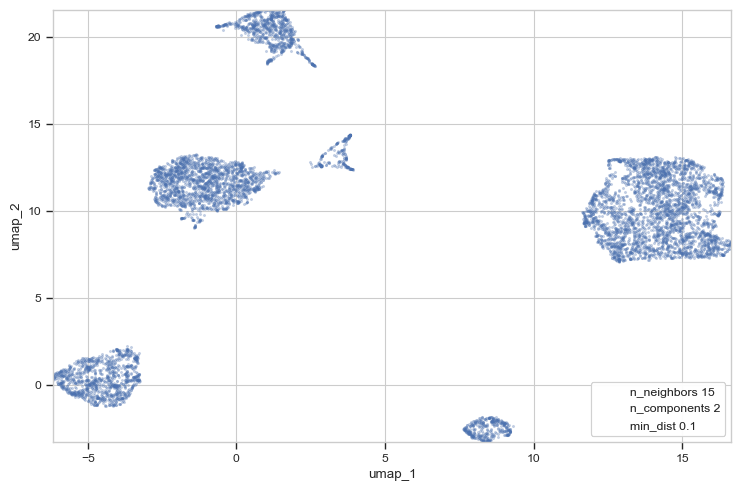

In [92]:
umap.default_view().plot(ex5)

We see that UMAP clustered our events but we don't really know if those clusters make sense. Lets color the events by human ground truth.

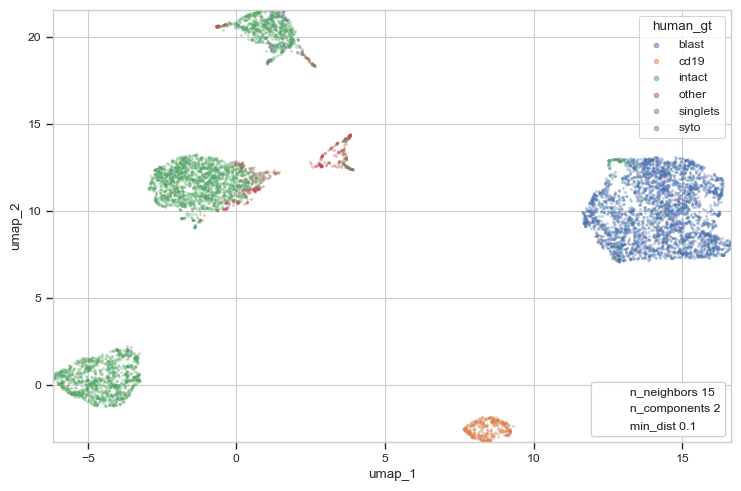

In [94]:
umap.default_view(huefacet="human_gt").plot(ex5)

Now we can see that those clusters reflect quite well the cell population found by human operators. We can also run a clustering algorithm on the embedded data. Here we use HDBSCAN.

In [114]:
clustering = flow.HDBSCANOp(name = "hdbscan", min_cluster_size  = 25, channels= ["umap_1", "umap_2"])
clustering.estimate(ex5)

ex6 = clustering.apply(ex5)

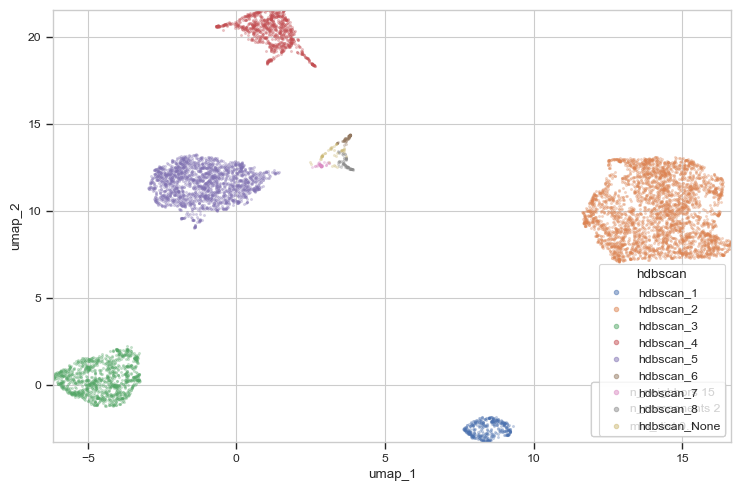

In [115]:
umap.default_view(huefacet="hdbscan").plot(ex6)

## Machine Learning

Python is especially powerful when it comes to the number of machine learning packages. In the following we load a Deep Learning model from the popular platform Hugging Face. [flowformer](https://huggingface.co/matth/flowformer) is model trained on B-ALL FCM data for detection of blast cells.

In [116]:
from transformers import AutoModel
flowformer = AutoModel.from_pretrained("matth/flowformer", trust_remote_code=True)


Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


Now we need to prepare our FCM data to be a suitable input for the model. The model expects the markers to ordered in a particular manner. And we also need to convert our data into a Tensor (the datatype of [Pytorch](https://pytorch.org/)).

In [117]:
import torch
markers = ['TIME','FSC-A', 'FSC-W', 'SSC-A', 'CD20', 'CD10', 'CD45', 'CD34', 'CD19', 'CD38', 'SY41']
events_tensor = torch.Tensor(ex6.data[markers].to_numpy()).unsqueeze(dim=0)


Now we can simply pass our events for the prediction.

In [118]:
prediction = flowformer(events_tensor)
prediction["class_prob"] = torch.nn.functional.sigmoid(prediction["logits"])

"class_prob" contains the predicted class probabilities of our model. 

In [119]:
prediction["class_prob"]

tensor([[0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003]],
       grad_fn=<SigmoidBackward0>)

We consider all events with a predicted probability over 0.5 as blasts and all less or equal 0.5 as non-blasts.

In [120]:
prediction["class_membership"] = (prediction["class_prob"] > 0.5).squeeze().numpy()

In [121]:
prediction["class_membership"]

array([False, False, False, ..., False, False, False])

The result can be plotted in our UMAP by adding the prediction as condition.

In [122]:
ex6.add_condition("blast_pred",dtype="bool", data =prediction["class_membership"])


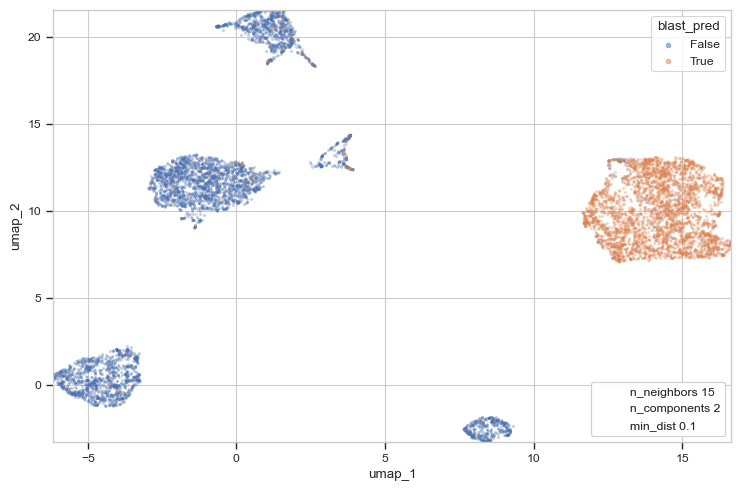

In [127]:
umap.default_view(huefacet = "blast_pred").plot(ex6)

In the UMAP plot we can see that the model predicted the this one cluster as blast cluster. But we can also get more percise performance results using a nother common Python Machine Learning toolkit called sklearn.

In [130]:
from sklearn.metrics import classification_report
print(classification_report(ex6.data["blast"], ex6["blast_pred"]))

              precision    recall  f1-score   support

       False       1.00      0.97      0.99      4923
        True       0.96      1.00      0.98      3417

    accuracy                           0.99      8340
   macro avg       0.98      0.99      0.98      8340
weighted avg       0.99      0.99      0.99      8340

